In [11]:
# make relevant imports
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

# set plotting parameters
mpl.rc('text', usetex = True)
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [12]:
# Import data only for Italy

raw_data = pd.read_csv('owid-covid-data.csv', parse_dates=['date']).sort_index()
country = 'Italy'
data = raw_data[raw_data['location']==country]
data.set_index('date', inplace=True)

In [13]:
# Keep smoothed data

deaths = data['new_deaths_smoothed'].fillna(0).to_numpy()
cases = data['new_cases_smoothed'].fillna(0).to_numpy()

# normalized cases
nn_cases = cases/max(cases)

In [14]:
# define capture_recapture function
T_end = len(cases)

CRC_cases = np.zeros(len(cases)-1)

CRC_error = np.zeros(len(cases)-1)

# compute CRC estimate for cases
for i in range(1, T_end-1):
    if (cases[i-1]-deaths[i]==0):
        CRC_cases[i] = 0
    else:
        CRC_cases[i] = cases[i]**2 / (cases[i-1]-deaths[i])
        
# compute CRC error estimate
for i in range(1, T_end-1):
    k1 = cases[i]**4 / (1+cases[i-1]-deaths[i])**3
    k2 = 4 * cases[i]**3 / (1+cases[i-1]-deaths[i])**2
    k3 = cases[i]**2 / (1+cases[i-1]-deaths[i])
    CRC_error[i] = max(k1 + k2 + k3, 0)
CRC_error_cumulative = CRC_error.cumsum()

sigma = 1.96 * np.sqrt(CRC_error_cumulative)

In [15]:
# Plot Capture Re-Capture (only) Adjustment to Cases

fig=plt.figure(figsize=(11, 6))
plt.plot(cases, linewidth=2, label='Diagnosed Cases')
plt.plot(CRC_cases,'--', linewidth=2, color='red', label='CRC-adjusted Cases');
plt.annotate(r'\textbf{Low Fidelity -- \\ Insufficient Adjustment }', xytext=(5,12000), xy=(0,0))
plt.annotate(r'\textbf{High Fidelity -- \\ Sufficient Adjustment}', xytext=(300,7500), xy=(0,0))
plt.ylabel('Cumulative Cases')
plt.xlabel('Days since Jan. 31, 2020')
#plt.title('Italy \n Capture-ReCapture Adjustment for Cases')
plt.savefig('Capture_Recapture_Italy', bbox_inches='tight',pad_inches=0.1);
plt.plot(CRC_cases, 'k--', linewidth=0.1)
plt.plot(CRC_cases + 1.96*np.sqrt(CRC_error), 'k--', linewidth=0.7, label='95\% Confidence Interval')
plt.plot(CRC_cases - 1.96*np.sqrt(CRC_error), 'k--', linewidth=0.7)

plt.scatter([160], [0.01], s=100, color='black')
plt.annotate(r'$T^*$', xytext=(190, 20000), xy=(160,0.03),arrowprops = dict(facecolor ='black',
                                  shrink = 1), zorder=4)

fig.patch.set_facecolor('white')
plt.legend()
#plt.savefig('CRC_Italy_Demonstration', bbox_inches='tight',pad_inches=0.1)
plt.show();

In [16]:
# import backcasting tools
import backcaster as bc

# Backcasting on adjusted data after T^*
pred = bc.BackCaster(deaths[1:], CRC_cases, t_star=160, window=10)
high = bc.BackCaster(deaths[1:], CRC_cases + 1.96*np.sqrt(CRC_error), t_star=160, window=10)
low = bc.BackCaster(deaths[1:], CRC_cases - 1.96*np.sqrt(CRC_error), t_star=160, window=10)

# fit
pred.fit_gp()
high.fit_gp()
low.fit_gp()

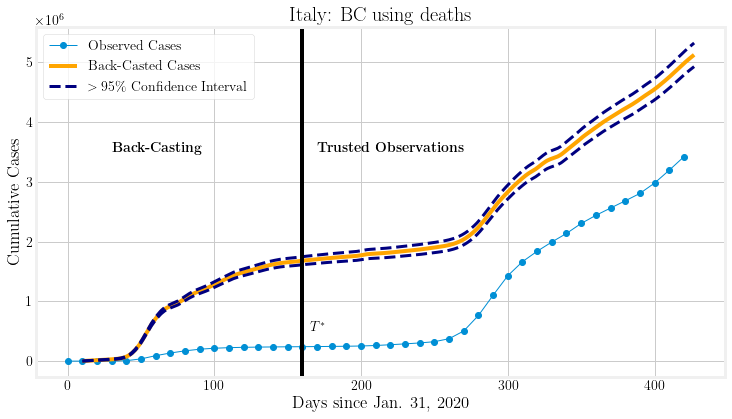

In [18]:
# Plot Result

fig=plt.figure(figsize=(11,6))
fig.patch.set_facecolor('white')

# predictions
plt.plot(np.arange(len(cases))[::10], cases.cumsum()[::10],'-o', linewidth=1, label='Observed Cases')
plt.plot(np.arange(pred.window, pred.window+len(pred.pred)), pred.pred.cumsum(), color='orange', label='Back-Casted Cases')
plt.plot(np.arange(pred.window, pred.window+len(pred.pred)), high.pred.cumsum(), '--', c='navy', linewidth=3, label=r'$>95\%$ Confidence Interval')
plt.plot(np.arange(pred.window, pred.window+len(pred.pred)), low.pred.cumsum(), '--', c='navy', linewidth=3)
plt.legend()
plt.title('Italy: BC using deaths')
plt.xlabel('Days since Jan. 31, 2020')
plt.ylabel('Cumulative Cases')
# x coordinates for the lines
xcoords = [160]
# colors for the lines
colors = ['b']

# figure details
for xc,c in zip(xcoords,colors):
    plt.axvline(x=xc,c='k')
plt.annotate(r'$T^*$', xytext=(165, 500000), xy=(160, 0))
plt.annotate(r'\textbf{Trusted Observations}', xytext=(170, 3500000), xy=(190, 200000))
plt.annotate(r'\textbf{Back-Casting}', xytext=(30, 3500000), xy=(190, 200000))
#plt.savefig('CRC_Italy_Backcasting', bbox_inches='tight',pad_inches=0.1)
plt.show()